In [1]:
cd("../../../temp")

In [2]:
]activate temp

  Activating project at `c:\Users\Work\Documents\Personal\Work\classes\PUCP 2024-II\repo\temp\temp`


## 1. A simulation exercise in regularization framework: sparsity in population coefficients

In [3]:
using Pkg
using CSV
using Distributions
using DataFrames
using Dates
using Plots
using Random
using LinearAlgebra
using LaTeXStrings
using Lasso
# using MLBase
using Statistics
using GLMNet
using MLJ

In [4]:
function gen_data(n::Int, p::Int, regime::String="sparse")

    # constants chosen to get R^2 of approximately .80
    if regime == "sparse"
        beta = ((1 ./ [1:p;]) .^ 2) * 7
    elseif regime == "dense"
        beta = sort(rand(Uniform(0.9, 1), p), rev=true)
    end

    function true_fn(x)
        return x * beta
    end

    X = rand(Uniform(-0.5, 0.5), n, p)
    gX = true_fn(X)
    y = gX .+ randn(n)
    Xpop = rand(Uniform(-0.5, 0.5), 100000, p)  # almost population limit
    gXpop = true_fn(Xpop)
    ypop = gXpop .+ randn(100000)
    return X, y, gX, Xpop, ypop, gXpop, beta
end

gen_data (generic function with 2 methods)

### Approximate sparse coefficients

We are going to simulate a data generating process which coefficients vector is sparse. A set of coefficients is said to be approximate sparse if it satisfies the following property:


\begin{equation*}

\beta_j \propto \frac{1}{j^2}, \quad \forall j=1,2,\dots,p

\end{equation*}

In other words, the predictive power relies in a small subset of the coefficients vector (the larger ones).

In [5]:
n = 100
p = 400
X, y, gX, Xpop, ypop, gXpop, betas = gen_data(n, p, "sparse");

We can plot the set of (sorted) coefficients' magnitudes to visualize their behavior

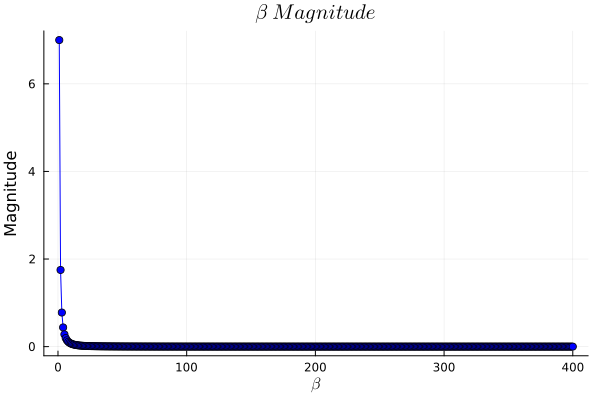

In [6]:
plot(1:length(betas),abs.(betas),seriestype=:path,color=:blue, labels = false,
    marker=:circle,markersize=4,xlabel=L"\beta",ylabel="Magnitude",
    title=L"\beta \ Magnitude")


As you may already notice, we are woking in a high dimensional setting ($p>n$). Let's test the dimensional reduction capabilities of the regularization methods. We would like to select only features which provide the most predictive power.

Remember that the general regularization problem (in p-norm) is the following:

\begin{equation*}

\min_{\beta_j \in \beta} \sum_{i=1}^{n}(Y_i - \beta^{\prime}X_i)^2 + \lambda\lVert \beta \lVert_p

\end{equation*}

where

\begin{equation*}

\lVert \beta \lVert_p = \left(\sum_{\beta_j \in \beta}\left|{\beta_{j}}^{p}\right|\right) ^{1/p}

\end{equation*}

When $p=1$, it is a Lasso (or L1) regularization . When $p=2$, it is a Ridge (or L2) regularization. We will explore the latter it in the next sessions

So, we fit a Lasso regularization. To tune the penalization parameter $\lambda$, we perform a cross-validation Lasso regression with $k=5$ folds.

In [7]:
model_l1 = glmnetcv(X, y, alpha=1.0, intercept=false, nfolds=5)
betas_l1 = model_l1.path.betas[:,argmin(model_l1.meanloss)];

Let's plot the estimated coefficients vs the population parameters

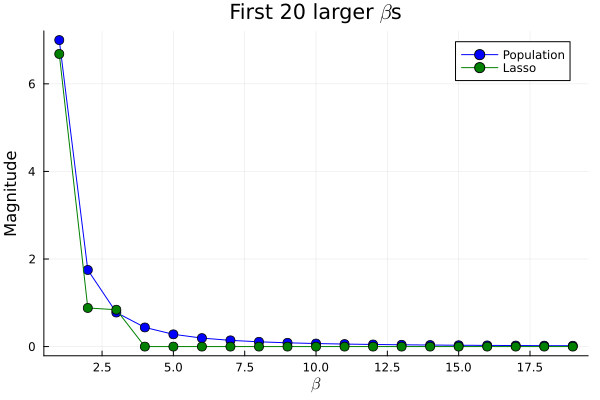

In [8]:
plot(1:19, abs.(betas[1:19]), label="Population", color=:blue, marker=:circle, markersize=5)
plot!(1:19, abs.(betas_l1[1:19]), label="Lasso", color=:green, marker=:circle, markersize=5)
title!(L"First 20 larger $\beta$s")
xlabel!(L"$\beta$")
ylabel!("Magnitude")

The main conclusion of this exercise is that Lasso regularization fits scenearios of approximate sparse coefficients because it select a small subset with high predictive power. The linear predictor provided by Lasso may not be the BLP, but works well under high dimensionality.

## 2. A Simple Case Study using Wage Data from 2015

### Data

We consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [9]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = CSV.read(download(file), DataFrame,
                types = Dict(:occ2 => String, :ind2 => String))
                

Row,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,String,Float64,String
1,9.61538,2.26336,1,0,0,0,1,0,0,0,0,1,7.0,0.49,0.343,0.2401,3600.0,11,8370.0,18
2,48.0769,3.8728,0,0,0,0,1,0,0,0,0,1,31.0,9.61,29.791,92.3521,3050.0,10,5070.0,9
3,11.0577,2.40313,0,0,1,0,0,0,0,0,0,1,18.0,3.24,5.832,10.4976,6260.0,19,770.0,4
4,13.9423,2.63493,1,0,0,0,0,1,0,0,0,1,25.0,6.25,15.625,39.0625,420.0,1,6990.0,12
5,28.8462,3.36198,1,0,0,0,1,0,0,0,0,1,22.0,4.84,10.648,23.4256,2015.0,6,9470.0,22
6,11.7308,2.46222,1,0,0,0,1,0,0,0,0,1,1.0,0.01,0.001,0.0001,1650.0,5,7460.0,14
7,19.2308,2.95651,1,0,1,0,0,0,0,0,0,1,42.0,17.64,74.088,311.17,5120.0,17,7280.0,14
8,19.2308,2.95651,0,0,1,0,0,0,0,0,0,1,37.0,13.69,50.653,187.416,5240.0,17,5680.0,9
9,12.0,2.48491,1,0,1,0,0,0,0,0,0,1,31.0,9.61,29.791,92.3521,4040.0,13,8590.0,19


In [10]:
y = data[:, "lwage"]
Z = select(data, Not([:wage, :lwage]))
column_names = names(Z)

18-element Vector{String}:
 "sex"
 "shs"
 "hsg"
 "scl"
 "clg"
 "ad"
 "mw"
 "so"
 "we"
 "ne"
 "exp1"
 "exp2"
 "exp3"
 "exp4"
 "occ"
 "occ2"
 "ind"
 "ind2"

The following figure shows the weekly wage distribution from the US survey data.

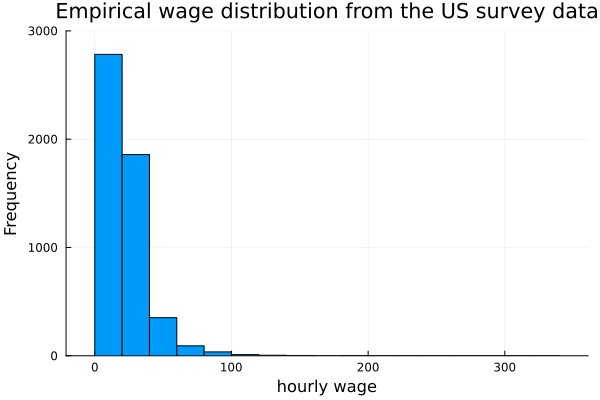

In [11]:
histogram(data.wage, bins=0:20:350, xlabel="hourly wage", ylabel="Frequency",
          title="Empirical wage distribution from the US survey data", label =false, ylim=(0, 3000))

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by the logarithm.

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$\log(\operatorname{wage}) = g(Z) + \epsilon.$$

In this notebook, we will evaluate *linear* prediction rules. In later notebooks, we will also utilize nonlinear prediction methods. In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$

Again, we generate $X$ in three ways:

1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., $\operatorname{exp}^2$ and $\operatorname{exp}^3$) and additional two-way interactions.

To evaluate the out-of-sample performance, we split the data first.

The basic model consists of $51$ regressors, and the flexible model has $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression and computing the $R^2$ on the test sample.

### Low dimensional specification (basic)

In [12]:
basic_formula = @formula(lwage ~ 1 + sex + exp1 + shs + hsg+ scl + clg + mw + so + we + occ2+ ind2)
Z_base = modelmatrix(basic_formula, data);

In [13]:
train_sample = rand(Float64, size(data)[1]) .< 0.75
test_sample = .!(train_sample)
y_train, y_test = y[train_sample], y[test_sample]
X_train, X_test = Z_base[train_sample, :], Z_base[test_sample, :];

In [14]:
lr_base = lm(X_train, y_train);

Let's calculate R-squared on the test set

In [15]:
basic_mse_testing = mean((GLM.predict(lr_base, X_test) - y_test) .^ 2)
basic_r2_testing = 1 - basic_mse_testing / var(y_test)

0.3039712440302672

### High-dimensional specification (flexible)

We repeat the same procedure for the flexible model.

In [16]:
flex_formula = @formula(lwage ~ 1 + sex + (exp1 + exp2 + exp3 + exp4) * (shs + hsg + clg + ad + mw + so + we + occ2 + ind2))
Z_flex = modelmatrix(flex_formula, data);

In [17]:
X_train, X_test = Z_flex[train_sample, :], Z_flex[test_sample, :];

In [18]:
lr_flex = lm(X_train, y_train);

In [19]:
basic_mse_testing = mean((GLM.predict(lr_flex, X_test) - y_test) .^ 2)
basic_r2_testing = 1 - basic_mse_testing / var(y_test)

0.2686017671832981

In [20]:
basic_mse_testing

0.23874496681624627

### Penalized regression: Lasso (flexible model)

We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We proceed by running a Lasso regression for the flexible model, tuned via cross-validation.

To properly penalize the coefficients, we must standarize the data, so each regressor is symmetrically penalized

In [21]:
using MLJ

In [22]:
LassoCVRegressor = @load LassoCVRegressor pkg=MLJScikitLearnInterface

[ Info: For silent loading, specify `verbosity=0`. 


import MLJScikitLearnInterface ✔


MLJScikitLearnInterface.LassoCVRegressor

In [23]:
lasso_flex = LassoCVRegressor(fit_intercept = false)
lasso_flex_machine = machine(lasso_flex, X_train, y_train)
fit!(lasso_flex_machine)
mean((y_test - MLJ.predict(lasso_flex_machine, X_test)) .^ 2)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJScikitLearnInterface.LassoCVRegressor` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{ScientificTypesBase.Continuous}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:AbstractVector{<:ScientificTypesBase.Continuous}}, AbstractVector{ScientificTypesBase.Continuous}}
└ @ MLJBase C:\Users\Work\

0.27510745009584353

Now we can plug in the theoretical $\lambda$. To do that we need to use HDM package for Julia

In [25]:
using HDMjl

In [26]:
hdm_lasso = rlasso(Z_flex, y, intercept = false)

Dict{String, Any} with 15 entries:
  "tss"          => 1675.17
  "dev"          => [-0.707422, 0.902016, -0.56766, -0.335859, 0.39119, -0.5085…
  "model"        => [1.0 1.0 … 0.0 0.0; 1.0 0.0 … 0.0 92.3521; … ; 1.0 0.0 … 0.…
  "loadings"     => [0.486704, 0.309018, 8.73484, 2.50069, 8.26401, 29.2493, 0.…
  "sigma"        => 0.486751
  "lambda0"      => 642.143
  "lambda"       => [312.533, 198.434, 5609.02, 1605.8, 5306.68, 18782.2, 64.45…
  "intercept"    => nothing
  "iter"         => 16
  "residuals"    => [-0.499717, 0.447141, -0.468254, -1.06095, 0.254799, -0.714…
  "rss"          => 1219.93
  "index"        => Bool[1, 0, 1, 0, 0, 0, 0, 0, 1, 1  …  0, 0, 0, 0, 0, 0, 0, …
  "beta"         => [2.70582, 0.0, 0.00919785, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31173…
  "options"      => Dict{String, Any}("intercept"=>false, "post"=>true, "meanx"…
  "coefficients" => [2.70582, 0.0, 0.00919785, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31173…

In [27]:
hdm_predictions = Z_flex * hdm_lasso["coefficients"];

In [28]:
1 - mean((hdm_predictions - y) .^ 2) / var(y)

0.27189583107407833

In [29]:
hdm_lasso["lambda0"]

642.1430202120721